In [1]:
!pip install -e /dss/dsshome1/04/di93zer/git/cellnet --no-deps

Obtaining file:///dss/dsshome1/04/di93zer/git/cellnet
  Preparing metadata (setup.py) ... done
  Running setup.py develop for cellnet

[notice] A new release of pip is available: 23.1.1 -> 23.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [5]:
from os.path import join

import numpy as np
import pandas as pd
import lightning.pytorch as pl
import dask.dataframe as dd
import torch
import matplotlib.pyplot as plt

from cellnet.estimators import EstimatorCellTypeClassifier
from cellnet.models import TabnetClassifier

/usr/local/lib/python3.8/dist-packages/merlin/dtypes/mappings/tf.py:52: UserWarning: Tensorflow dtype mappings did not load successfully due to an error: No module named 'tensorflow'
  warn(f"Tensorflow dtype mappings did not load successfully due to an error: {exc.msg}")


In [2]:
DATA_PATH = '/mnt/dssmcmlfs01/merlin_cxg_2023_05_15_sf-log1p'
CKPT_PATH = '/mnt/dssfs02/tb_logs/cxg_2023_05_15_tabnet/default/w_augment_4/checkpoints/val_f1_macro_epoch=45_val_f1_macro=0.847.ckpt'

In [3]:
cell_type_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/cell_type.parquet'))
tissue_general_mapping = pd.read_parquet(join(DATA_PATH, 'categorical_lookup/tissue_general.parquet'))
cell_type_hierarchy = np.load(join(DATA_PATH, 'cell_type_hierarchy/child_matrix.npy'))
tissue_general = dd.read_parquet(join(DATA_PATH, 'test'), columns='tissue_general').compute().to_numpy()
y_true = dd.read_parquet(join(DATA_PATH, 'test'), columns='cell_type').compute().to_numpy()

# Load model & predict

In [4]:
from utils import correct_labels

In [5]:
estim = EstimatorCellTypeClassifier(DATA_PATH)
estim.init_datamodule(batch_size=2048)
estim.model = TabnetClassifier.load_from_checkpoint(CKPT_PATH, **estim.get_fixed_model_params('tabnet'))
estim.trainer = pl.Trainer(logger=[], accelerator='gpu', devices=1)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
probas = estim.predict(estim.datamodule.test_dataloader())
y_pred = np.argmax(probas, axis=1)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████| 1684/1684 [05:41<00:00,  4.93it/s]


In [7]:
assert y_pred.shape[0] == y_true.shape[0]
y_pred_corr = correct_labels(y_true, y_pred, cell_type_hierarchy)

# Classification performance

In [8]:
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix

#### Overall performance

In [9]:
clf_report = pd.DataFrame(classification_report(y_true, y_pred_corr, output_dict=True)).T
clf_report_overall = clf_report.iloc[-3:].copy()
clf_report_per_class = clf_report.iloc[:-3].copy()

clf_report_overall

,precision,recall,f1-score,support
accuracy,0.907541,0.907541,0.907541,9.075406e-01
macro avg,0.822743,0.852199,0.830268,3.448832e+06
weighted avg,0.912285,0.907541,0.907862,3.448832e+06


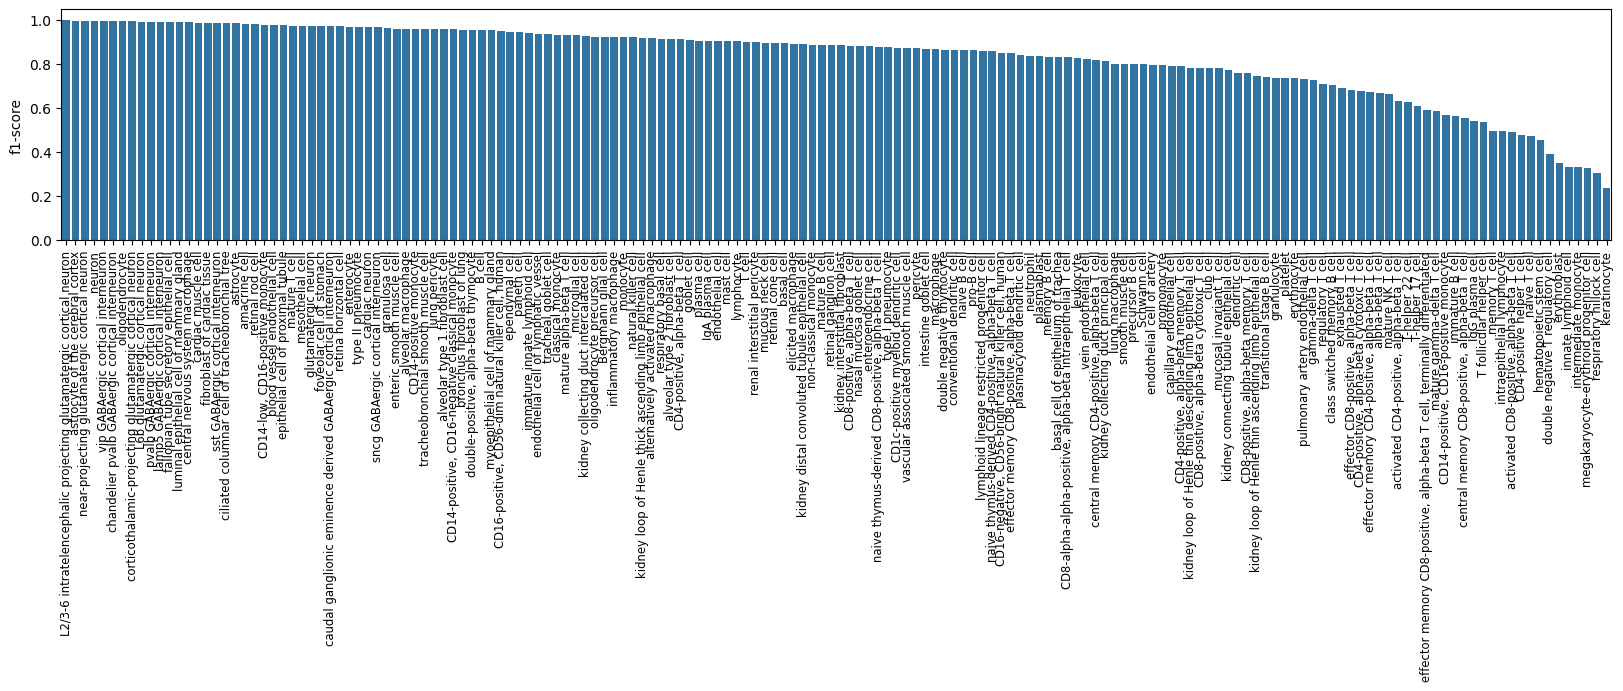

In [10]:
plt.rcParams['figure.figsize'] = (20, 3)

ax = sns.barplot(
    data=(
        clf_report_per_class
        .assign(
            cell_type=lambda df: df.index.to_series().astype(int).replace(cell_type_mapping['label'].to_dict())
        )
        .sort_values('f1-score', ascending=False)
    ),
    x='cell_type',
    y='f1-score',
    color='#1f77b4'
)
ax.tick_params(axis='x', labelrotation=90)
ax.set_xlabel('')
ax.xaxis.set_tick_params(labelsize='small');

#### Per cell type performance vs number of donors

In [11]:
# unique_donors_per_cell_type = (
#     dd.read_parquet(join(DATA_PATH, 'train'), columns=['cell_type', 'tech_sample'])
#     .groupby('cell_type')['tech_sample']
#     .nunique()
# ).compute()

cells_per_cell_type = (
    dd.read_parquet(join(DATA_PATH, 'train'), columns=['cell_type', 'tech_sample'])
    .groupby('cell_type')['tech_sample']
    .size()
).compute()

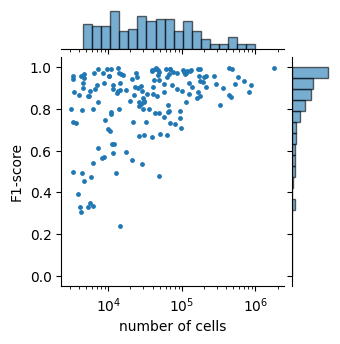

In [17]:
assert np.array_equal(
    clf_report_per_class['f1-score'].index.to_numpy().astype('i8'),
    cells_per_cell_type.index.to_numpy()
)

df = clf_report_per_class[['f1-score']].copy()
df['n_cells'] = cells_per_cell_type.to_numpy()
g = sns.JointGrid(x='n_cells', y='f1-score', data=df, height=3.5, marginal_ticks=False)
g = g.plot_joint(plt.scatter, s=6)
g.ax_marg_x.hist(df['n_cells'], bins=np.geomspace(4500, 1e6, 20), alpha=.6, edgecolor='black')
g.ax_marg_y.hist(df['f1-score'], bins=np.linspace(0, 1, 20), alpha=.6, orientation='horizontal', edgecolor='black')
g.set_axis_labels('number of cells', 'F1-score')
g.ax_joint.set_xscale('log')

g.ax_joint.get_figure().savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/f1-score_vs_n-cells.pdf', format='pdf')
g.ax_joint.get_figure().savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/f1-score_vs_n-cells.png', format='png', dpi=300)

# Visualize predictions

In [1]:
import yaml

import anndata
import scanpy as sc
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open('shortend_cell_types.yaml', 'r') as f:
    shortend_cell_types = yaml.safe_load(f)

In [6]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300 # If 'figure', uses the figure's dpi value.

sc.settings.figdir = '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/'

## predictions vs true labels

Plot TSNE embedding (based on 64 PCA components of the input features) and super-impose true labels and predicted labels

In [66]:
adata = anndata.AnnData(
    X=np.load(join(DATA_PATH, 'pca/x_pca_test_50.npy')), 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten(),
        'tissue': tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
    })
)
adata.obs['wrong_prediction'] = (adata.obs.y_true != adata.obs.y_pred).astype(str).astype('category')

/usr/local/lib/python3.8/dist-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [ ]:
sc.pp.subsample(adata, n_obs=200_000)
sc.tl.tsne(adata, use_rep='X')

In [ ]:
adata.write_h5ad('adata_tabnet.h5ad')

In [3]:
adata = anndata.read_h5ad('adata_tabnet.h5ad')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


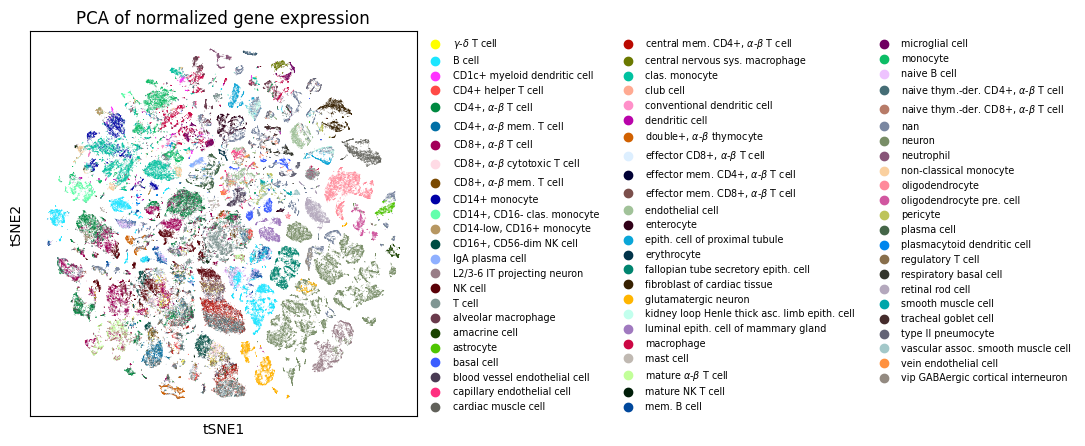

In [6]:
plt.rcParams['figure.figsize'] = (5, 5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq.index.tolist()[:70]
adata_plot = adata.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot)).astype(str)
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot)).astype(str)

# convert to shortened cell type names
adata_plot.obs['y_pred'] = adata_plot.obs['y_pred'].replace(shortend_cell_types)
adata_plot.obs['y_true'] = adata_plot.obs['y_true'].replace(shortend_cell_types)

sc.pl.tsne(
    adata_plot, 
    color='y_true', 
    legend_fontsize='x-small', 
    ncols=1, 
    title='PCA of normalized gene expression',
    # save='_raw_features.png'
)

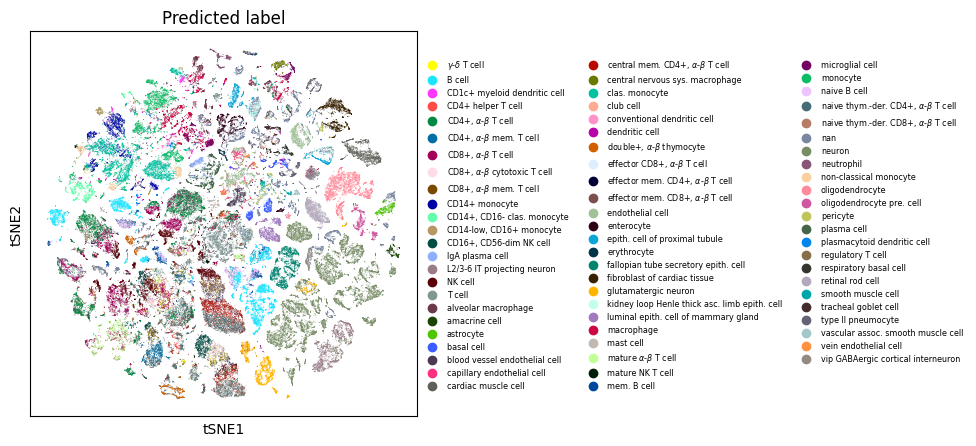

In [8]:
sc.pl.tsne(adata_plot, color='y_pred', legend_fontsize='xx-small', ncols=1, title='Predicted label')

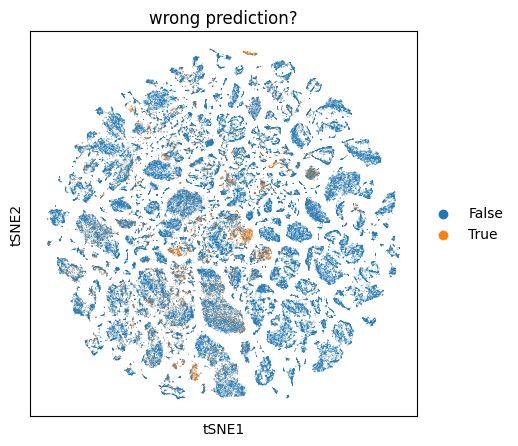

In [9]:
sc.settings.figdir = '/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/'
sc.pl.tsne(
    adata, 
    color='wrong_prediction', 
    title='wrong prediction?',
    # save='_wrong_predictions.png'
)

## Visualize learned features

Plot TSNE embedding (based on last layer of trained neural network) and super-impose true labels and predicted labels

In [ ]:
# get feature embedding
estim.model.predict_bottleneck = True
x_emb = estim.predict(estim.datamodule.test_dataloader())
estim.model.predict_bottleneck = False

In [ ]:
adata_emb = anndata.AnnData(
    X=x_emb, 
    obs=pd.DataFrame({
        'y_true': cell_type_mapping.loc[y_true].to_numpy().flatten(), 
        'y_pred': cell_type_mapping.loc[y_pred_corr].to_numpy().flatten(),
        'tissue': tissue_general_mapping.loc[tissue_general].to_numpy().flatten()
    })
)
adata_emb.obs['wrong_prediction'] = (adata_emb.obs.y_true != adata_emb.obs.y_pred).astype(str).astype('category')

In [ ]:
sc.pp.subsample(adata_emb, n_obs=200_000)
# reduce to 50 dim before computing TSNE embedding
sc.pp.pca(adata_emb, n_comps=50)
sc.tl.tsne(adata_emb)

In [74]:
adata_emb.write_h5ad('adata_emb_tabnet.h5ad')

In [10]:
adata_emb = anndata.read_h5ad('adata_emb_tabnet.h5ad')

/usr/local/lib/python3.8/dist-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


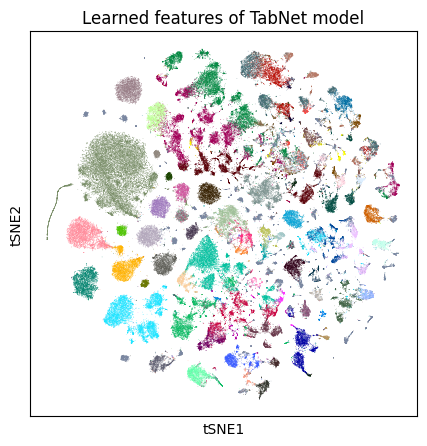

In [11]:
plt.rcParams['figure.figsize'] = (5, 5)

cell_freq = adata.obs.y_true.value_counts()
# only plot most frequent cell types to not overload the color scale
cells_to_plot = cell_freq.index.tolist()[:70]
adata_plot = adata_emb.copy()
adata_plot.obs['y_pred'] = adata_plot.obs.y_pred.mask(~adata_plot.obs.y_pred.isin(cells_to_plot)).astype(str)
adata_plot.obs['y_true'] = adata_plot.obs.y_true.mask(~adata_plot.obs.y_true.isin(cells_to_plot)).astype(str)

# convert to shortened cell type names
adata_plot.obs['y_pred'] = adata_plot.obs['y_pred'].replace(shortend_cell_types)
adata_plot.obs['y_true'] = adata_plot.obs['y_true'].replace(shortend_cell_types)

ax = sc.pl.tsne(adata_plot, color='y_true', legend_fontsize='x-small', ncols=1, title='Learned features of TabNet model', show=False)
ax.get_legend().remove()
# plt.savefig('/dss/dsshome1/04/di93zer/git/cellnet/figure-plots/figure1/tsne_learned_features.png')